# Logistic Regression Model

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

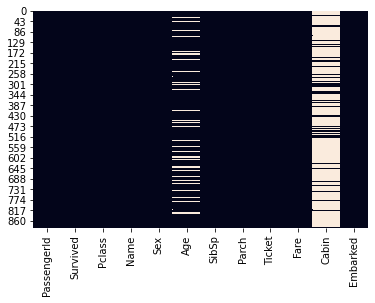

In [5]:
sns.heatmap(df.isnull(), cbar=False)

In [9]:
df['Survived'] = df['Survived'].astype(bool)
df.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
False,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
True,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [10]:
survived_mean_age = df['Age'].loc[df['Survived'] == True].mean()
died_mean_age = df['Age'].loc[df['Survived'] == False].mean()

In [12]:
# Setting missing age values to the average of those who died and survived
df['Age'].loc[(df['Survived'] == True) & (df['Age'].isna())] = survived_mean_age
df['Age'].loc[(df['Survived'] == False) & (df['Age'].isna())] = died_mean_age

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

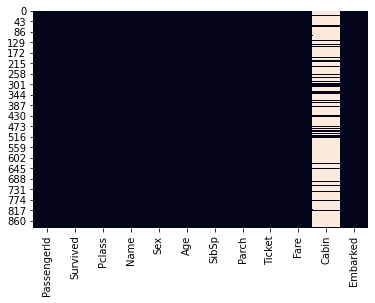

In [14]:
sns.heatmap(df.isnull(), cbar=False)
# I am thinking about dropping the cabin variable, because there are not enough values to determine the missing ones
# But for now I won't use that information to train the model

In [15]:
# saving those changes, so that I do not have to do that again.
df.to_csv('../data/processed_titanic.csv')

# Training the model

In [33]:
# Additional transformation of Sex variable to be done: female (1) and male(0)
df['Sex'].loc[df['Sex'] == 'male'] = 0.0
df['Sex'].loc[df['Sex'] == 'female'] = 1.0

In [50]:
# Define X and y
X = df[['Pclass', 'Sex', 'Age', 'Fare']]
y = df['Survived']

In [66]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [67]:
# Initialize model
model = LogisticRegression()

# Train the model with test data
model.fit(X_train, y_train)

LogisticRegression()

In [68]:
# Evaluating the model
y_pred_test = model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.8026905829596412